# 599-01-SU23: Capstone Project

## Resolve dependencies

In [1]:
#!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

## Globally import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import imageio
import glob
import datetime as dt
import os
import shutil
import pathlib
from pathlib import Path
import zipfile
import remotezip as rz
import tqdm
import itertools
import collections
from IPython import display
from urllib import request

import cv2
#import keras
#from keras.models import Sequential
from keras import layers
#from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.layers import Flatten, Dense, Dropout
from keras import backend as K
import skimage
from skimage import io
from skimage import transform
from skimage.color import rgb2gray
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Dense, Dropout, Rescaling
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow_docs.vis import embed
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pywt

import einops

%matplotlib inline

## Set seeds

In [3]:
random.seed(1699)
tf.random.set_seed(1699)

## Set zip data path

In [4]:
cd2_path = os.path.join(r'C:\Users\acarr\Documents\ads_data_local\capstone', r'Celeb-DF-v2.zip')
print(cd2_path)

C:\Users\acarr\Documents\ads_data_local\capstone\Celeb-DF-v2.zip


## Define data structure hyperparameters

In [5]:
file_format = '.mp4'

class_cnt = 3
FILES_PER_CLASS = 50

train_percent = .6
val_percent = .2
test_percent = .2

n_frames = 300
image_height = 300
image_width = 300

batch_size = 32

## Show sample of files

In [6]:
def get_zip_files_paths(zip_path):
    """
    List the files in each class of the dataset given a local path to a zip file.

    Args:
      zip_path: A local path to the zip file.

    Returns:
      List of files in each of the classes.
    """
    files = []
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return [f for f in files if f.endswith(file_format)]

files = get_zip_files_paths(cd2_path)
print(f'First 10 files:\n{files[:10]}')
print(f'File count: {len(files)}')

First 10 files:
['Celeb-real/id0_0000.mp4', 'Celeb-real/id0_0001.mp4', 'Celeb-real/id0_0002.mp4', 'Celeb-real/id0_0003.mp4', 'Celeb-real/id0_0004.mp4', 'Celeb-real/id0_0005.mp4', 'Celeb-real/id0_0006.mp4', 'Celeb-real/id0_0007.mp4', 'Celeb-real/id0_0008.mp4', 'Celeb-real/id0_0009.mp4']
File count: 6529


Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

## Setup for partition by `label`

In [7]:
def get_class(fname):
    """
    Retrieve the name of the class given a filename.

    Args:
        fname: Name of the file in the Celeb-real dataset.

    Returns:
        Class that the file belongs to.
    """
    #print(os.path.dirname(fname).split(os.path.sep)[-1])
    return os.path.dirname(fname).split(os.path.sep)[-1]

In [8]:
def get_files_per_class(files):
    """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        #print(f'{os.path.join(class_name, fname)}')
        #files_for_class[class_name].append(os.path.join(class_name, fname))
        #files_for_class[class_name].append(pathlib.Path(fname))
        files_for_class[class_name].append(fname)
    return files_for_class

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset. 

In [9]:
files_for_class = get_files_per_class(files)
#print(f'file_for_class:\n{files_for_class}')
classes = list(files_for_class.keys())
classes

['Celeb-real', 'Celeb-synthesis', 'YouTube-real']

In [10]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))
print('Num videos for class[1]:', len(files_for_class[classes[1]]))
print('Num videos for class[2]:', len(files_for_class[classes[2]]))

Num classes: 3
Num videos for class[0]: 590
Num videos for class[1]: 5639
Num videos for class[2]: 300


Create a new function called `select_classes_subset` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [11]:
def select_classes_subset(files_for_class, classes, files_per_class):
    """
    Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
    """
    files_subset = dict()

    for idx, class_name in enumerate(classes):
        print(f'Class index: {idx}')
        print(f'Class name: {class_name}')
        class_files = files_for_class[class_name]
        file_cnt = len(class_files)
        print(f'File count: {file_cnt}\n')
        
        files_subset[class_name] = class_files[:files_per_class]

    return files_subset, file_cnt

In [12]:
files_subset, file_cnt = select_classes_subset(files_for_class, classes[:class_cnt], FILES_PER_CLASS)
#print(files_subset)
list(files_subset.keys())

Class index: 0
Class name: Celeb-real
File count: 590

Class index: 1
Class name: Celeb-synthesis
File count: 5639

Class index: 2
Class name: YouTube-real
File count: 300



['Celeb-real', 'Celeb-synthesis', 'YouTube-real']

## Partition files into train, val, and test sets

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [13]:
def load_zip_file(zip_path,
                      to_dir,
                      file_names):
    """
    Extracts the specified files from a zip file to a directory.

    Args:
        zip_path: Path to the zip file.
        to_dir: Path to the directory to extract the files to.
        file_names: Names of the files to extract.
    """
    with zipfile.ZipFile(zip_path) as zip:
        for fn in file_names:
            #print(f'Filename: {fn}')
            class_name = get_class(fn)
            zip.extract(fn, os.path.join(to_dir, class_name))
            unzipped_file = os.path.join(to_dir, class_name, fn)

            fn = os.path.basename(fn)
            output_file = os.path.join(to_dir, class_name, fn)
            os.rename(unzipped_file, output_file)
            
#The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

def split_class_lists(files_for_class, count):
    """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
        files_for_class: Files belonging to a particular class of data.
        count: Number of files to download.

    Returns:
        Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for file_class in files_for_class:
        #print(f'Class: {file_class}')
        #split_files.extend([os.path.join(file_class, os.path.basename(f)).replace("\\", "/") for f in files_for_class[file_class][:count]])
        #remainder[file_class] = [os.path.join(file_class, os.path.basename(f)).replace("\\", "/") for f in files_for_class[file_class][count:]]
        split_files.extend(files_for_class[file_class][:count])
        remainder[file_class] = files_for_class[file_class][count:]
    return split_files, remainder

The following `partition_datasets` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [14]:
def partition_datasets(zip_path,
                            class_cnt,
                            splits,
                            download_dir):
    """
    Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
        zip_path: A local path to a ZIP file with the data.
        class_cnt: Number of labels.
        splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
                (value is number of files per split).
        download_dir: Directory to download data to.

    Return:
        Mapping of the directories containing the subsections of data.
    """
    files = get_zip_files_paths(zip_path)
    for f in files:
        path = os.path.normpath(f)
        #print(f'Path: {path}')
        tokens = path.split(os.sep)
        #print(f'Tokens: {tokens}')
        if len(tokens) < 2:
            files.remove(f) # Remove that item from the list if it does not have a filename
            print(f'File to remove: {f}')
        #else:
            #print(f'File to include: {f}')

    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:class_cnt]

    for c in classes:
        #print(f'Class: {c}')
        random.shuffle(files_for_class[c])

    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in classes}
    #print(f'files_for_class:\n{files_for_class}')

    dirs = {}
    for idx, c in enumerate(classes):
        subfiles_for_class = {c: files_for_class[c]}
        print(f'\nIndex: {idx}\nClass: {c}')
        file_cnt = len(subfiles_for_class[c])
        print(f'Number of class files: {file_cnt}')
        print(f'Zip path: {zip_path}')
        for split_name, split_percent in splits.items():
            print(f'Split name: {split_name}\nSplit %: {split_percent}')
            split_dir = os.path.join(download_dir, split_name)
            print(f'Split dir: {split_dir}')
            part_file_cnt = int(round(split_percent*file_cnt, 0))
            print(f'Split count: {part_file_cnt}')
            #print(f'Class files:\n{files_for_class[c]}')
            split_files, subfiles_for_class = split_class_lists(subfiles_for_class,
                                                                part_file_cnt)
            #print(f'Split files: {split_files}')
            #print(f'Files for class: {files_for_class}')
            load_zip_file(zip_path, split_dir, split_files)
            dirs[split_name] = split_dir

    return dirs

download_dir = pathlib.Path('../data/celeb-split/')

if os.path.exists(download_dir):
    try:
        # Try to remove the folder with rmdir() if it's empty
        os.rmdir(download_dir)
        print(f"Folder '{download_dir}' removed successfully.")
    except OSError:
        # If the folder is not empty, use rmtree() to delete it
        shutil.rmtree(download_dir)
        print(f"Folder '{download_dir}' and its contents removed successfully.")
else:
    print(f"Folder '{download_dir}' does not exist.")

subset_paths = partition_datasets(cd2_path,
                                  class_cnt=class_cnt,
                                  splits={"train": train_percent,
                                          "val": val_percent,
                                          "test": test_percent},
                                  download_dir=download_dir)

Folder '..\data\celeb-split' and its contents removed successfully.

Index: 0
Class: Celeb-real
Number of class files: 590
Zip path: C:\Users\acarr\Documents\ads_data_local\capstone\Celeb-DF-v2.zip
Split name: train
Split %: 0.6
Split dir: ..\data\celeb-split\train
Split count: 354
Split name: val
Split %: 0.2
Split dir: ..\data\celeb-split\val
Split count: 118
Split name: test
Split %: 0.2
Split dir: ..\data\celeb-split\test
Split count: 118

Index: 1
Class: Celeb-synthesis
Number of class files: 5639
Zip path: C:\Users\acarr\Documents\ads_data_local\capstone\Celeb-DF-v2.zip
Split name: train
Split %: 0.6
Split dir: ..\data\celeb-split\train
Split count: 3383
Split name: val
Split %: 0.2
Split dir: ..\data\celeb-split\val
Split count: 1128
Split name: test
Split %: 0.2
Split dir: ..\data\celeb-split\test
Split count: 1128

Index: 2
Class: YouTube-real
Number of class files: 300
Zip path: C:\Users\acarr\Documents\ads_data_local\capstone\Celeb-DF-v2.zip
Split name: train
Split %: 0.6
Sp

After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [15]:
video_cnt_train = len(list(download_dir.glob('train/*/*.mp4')))
video_cnt_val = len(list(download_dir.glob('val/*/*.mp4')))
video_cnt_test = len(list(download_dir.glob('test/*/*.mp4')))
video_total = video_cnt_train + video_cnt_val + video_cnt_test
print(f"Total videos: {video_total}")

Total videos: 6529


You can also preview the directory of data files now.

## Create frames from each video file

The `frames_from_video_file` function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file, and returns them as a NumPy `array`.
To reduce memory and computation overhead, choose a **small** number of frames. In addition, pick the **same** number of frames from each video, which makes it easier to work on batches of data.


In [16]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float16)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [17]:
def frames_from_video_file(video_path,
                           n_frames,
                           output_size=(image_height, image_width),
                           frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

## Visualize video data

The `frames_from_video_file` function that returns a set of frames as a NumPy array. Try using this function on a new video from [Wikimedia](https://commons.wikimedia.org/wiki/Category:Videos_of_sports){:.external} by Patrick Gillett:

In [18]:
folder_path = r'C:\Users\acarr\Documents\GitHub\599_team_project\data\celeb-split\train\Celeb-synthesis'

# Get a list of all the files in the folder
files = os.listdir(folder_path)

# Select a random file from the list
random_file = random.choice(files)

# Create the full path to the random file
random_file_path = os.path.join(folder_path, random_file)

print(f'Random file path: {random_file_path}')

Random file path: C:\Users\acarr\Documents\GitHub\599_team_project\data\celeb-split\train\Celeb-synthesis\id39_id47_0001.mp4


In [19]:
sample_video = frames_from_video_file(random_file_path, n_frames = n_frames)
sample_video.shape

(200, 200, 200, 3)

In [20]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')


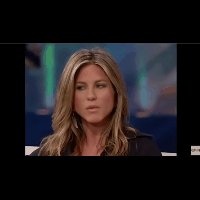

In [21]:
to_gif(sample_video)

## Setup frame generator

Next, define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [22]:
class FrameGenerator:
    def __init__(self, path_str, n_frames, training = False):
        """
        Returns a set of frames with their associated label. 

          Args:
            path: Video file paths.
            n_frames: Number of frames. 
            training: Boolean to determine if training dataset is being created.
        """
        self.path = Path(path_str)
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        #print(f'Video Paths:\n{video_paths}')
        #print(f'Classes:\n{classes}')

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            #print(f'Path: {path}')
            #print(f'Name: {name}')
            video_frames = frames_from_video_file(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label

Test out the `FrameGenerator` object before wrapping it as a TensorFlow Dataset object. Moreover, for the training dataset, ensure you enable training mode so that the data will be shuffled.

In [23]:
print(os.path.join(r'C:\Users\acarr\Documents\GitHub\599_team_project\data\celeb-split',
                   'train'))
print(subset_paths)
fg = FrameGenerator(subset_paths['train'],
                    n_frames,
                    training=True)

frames, label = next(fg())

print(f"Frame shape: {frames.shape}")
print(f"Label: {label}")

C:\Users\acarr\Documents\GitHub\599_team_project\data\celeb-split\train
{'train': '..\\data\\celeb-split\\train', 'val': '..\\data\\celeb-split\\val', 'test': '..\\data\\celeb-split\\test'}
Frame shape: (200, 200, 200, 3)
Label: 1


## Setup tensorflow input pipeline

Finally, create a TensorFlow data input pipeline. This pipeline that you create from the generator object allows you to feed in data to your deep learning model. In this video pipeline, each element is a single set of frames and its associated label. 

In [24]:
# Create the training set
output_signature = (tf.TensorSpec(shape=(None, None, None, 3),
                                  dtype=tf.float16),
                    tf.TensorSpec(shape=(), dtype=tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'],
                                                         n_frames,
                                                         training=True),
                                          output_signature=output_signature)

Check to see that the labels are shuffled. 

In [25]:
for frames, labels in train_ds.take(10):
    print(labels)

tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)


In [26]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'],
                                                       n_frames),
                                        output_signature=output_signature)

In [27]:
# Create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'],
                                                        n_frames),
                                         output_signature=output_signature)

In [28]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of training set of frames: (200, 200, 200, 3)
Shape of training labels: ()
Shape of validation set of frames: (200, 200, 200, 3)
Shape of validation labels: ()
Shape of test set of frames: (200, 200, 200, 3)
Shape of test labels: ()


## Configure the dataset for performance

Use buffered prefetching such that you can yield data from the disk without having I/O become blocking. Two important functions to use while loading data are:

* `Dataset.cache`: keeps the sets of frames in memory after they're loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch`: overlaps data preprocessing and model execution while training.
Refer to [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance) for details.

### TF shuffle

In [29]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

### TF batch

To prepare the data to be fed into the model, use batching as shown below. Notice that when working with video data, such as AVI files, the data should be shaped as a five dimensional object. These dimensions are as follows: `[batch_size, number_of_frames, height, width, channels]`. In comparison, an image would have four dimensions: `[batch_size, height, width, channels]`. The image below is an illustration of how the shape of video data is represented.

![Video data shape](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)


In [30]:
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

### Review datasets' dimensions

In [31]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')
#print(train_frames)
print(train_labels)

val_frames, val_labels = next(iter(val_ds))
print(f'\nShape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')
print(val_labels)

test_frames, test_labels = next(iter(test_ds))
print(f'\nShape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')
print(test_labels)

Shape of training set of frames: (32, 200, 200, 200, 3)
Shape of training labels: (32,)
tf.Tensor([1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int16)

Shape of validation set of frames: (32, 200, 200, 200, 3)
Shape of validation labels: (32,)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int16)

Shape of test set of frames: (32, 200, 200, 200, 3)
Shape of test labels: (32,)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int16)


In [32]:
print(f'Train dataset generator:\n{train_ds}')

Train dataset generator:
<BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>


## Train model

### Define model hyperparameters

In [33]:
target_epochs = 25

### $M_{1}$: chatGPT time distributed model

In [34]:
# Start training timer
start_time = dt.datetime.today()

#### Model setup

In [35]:
K.clear_session()

amc_m1v1_cnn_input_shape = (None, n_frames, image_height, image_width, 3)
print(f'Input shape: {amc_m1v1_cnn_input_shape}')

amc_m1v1_cnn_input = layers.Input(shape=(amc_m1v1_cnn_input_shape[1:]),
                                  dtype=tf.float16)
#resize = tf.keras.layers.Resizing(height=120,
#                                  width=120,
#                                  crop_to_aspect_ratio=False)(amc_m1v1_cnn_input)
rescale = layers.Rescaling(scale=1./255)(amc_m1v1_cnn_input)
conv1 = layers.TimeDistributed(layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu'))(rescale)
pool1 = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2)))(conv1)
conv2 = layers.TimeDistributed(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'))(pool1)
pool2 = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2)))(conv2)
conv3 = layers.TimeDistributed(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))(pool2)
pool3 = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2)))(conv3)
conv4 = layers.TimeDistributed(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))(pool3)
pool4 = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2)))(conv4)

flatten = layers.TimeDistributed(layers.Flatten())(pool4)
print(f'Flattened array shape: {flatten.shape}')

batch_norm1 = tf.keras.layers.BatchNormalization()(flatten)
dense1 = layers.TimeDistributed(layers.Dense(128, activation='relu'))(batch_norm1)
batch_norm2 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = layers.TimeDistributed(layers.Dense(80, activation='relu'))(batch_norm2)
batch_norm3 = tf.keras.layers.BatchNormalization()(dense2)
dense3 = layers.TimeDistributed(layers.Dense(80, activation='relu'))(batch_norm3)
batch_norm4 = tf.keras.layers.BatchNormalization()(dense3)
dense4 = layers.TimeDistributed(layers.Dense(80, activation='relu'))(batch_norm4)
amc_m1v1_cnn_output = layers.Dense(class_cnt, activation='softmax')(dense4[:, -1, :])

print(amc_m1v1_cnn_input)
print(conv1)
print(pool1)
print(conv2)
print(pool2)
print(conv3)
print(pool3)
print(conv4)
print(pool4)
print(dense1)
print(dense2)
print(dense3)
print(dense4)
print(amc_m1v1_cnn_output)

amc_m1v1_cnn = keras.Model(inputs=amc_m1v1_cnn_input,
                           outputs=amc_m1v1_cnn_output)
print(f'Keras model object: {amc_m1v1_cnn}')

Input shape: (None, 200, 200, 200, 3)
Flattened array shape: (None, 200, 1152)
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 200, 3), dtype=tf.float16, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100, 100, 16), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 50, 50, 16), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 25, 25, 32), dtype=tf.float32, name=None), name='time_distributed_2/Reshape_1:0', description="created by layer 'time_distributed_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 12, 12, 32), dtype=tf.float32, name=None), name='time_distributed_3/Reshape_1:0', description="created by layer 'time_distributed_3'")
KerasTensor(type_spec

#### Review parameters

In [36]:
amc_m1v1_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 200, 3  0         
                             )]                                  
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 200, 3)  0         
                                                                 
 time_distributed (TimeDistr  (None, 200, 100, 100, 16  448      
 ibuted)                     )                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 200, 50, 50, 16)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 200, 25, 25, 32)  4640      
 tributed)                                                   

Frames: (200, 200, 200, 3)


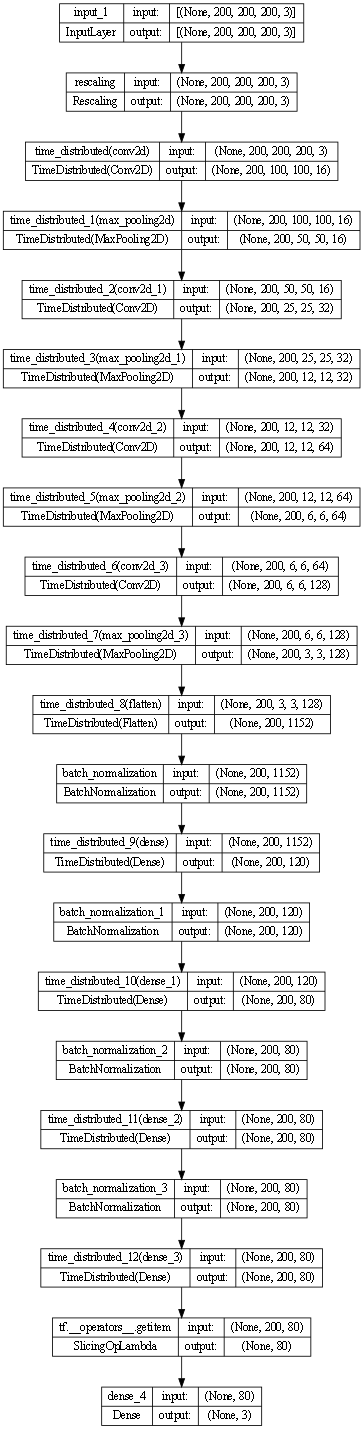

In [37]:
# Visualize the model
print(f'Frames: {frames.shape}')
keras.utils.plot_model(amc_m1v1_cnn,
                       expand_nested=True,
                       dpi=60,
                       show_shapes=True)

 #### Compile and fit

In [38]:
amc_m1v1_cnn.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

amc_m1v1_cnn_hist = amc_m1v1_cnn.fit(train_ds,
                                     epochs=target_epochs,
                                     validation_data=val_ds,
                                     callbacks=tf.keras.callbacks.EarlyStopping(patience=2,
                                                                                monitor='val_loss'))

123/123 [==============================] - 13883s 111s/step - loss: 0.5030 - accuracy: 0.8573 - val_loss: 0.9174 - val_accuracy: 0.8637


In [39]:
# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Training Start Time = {start_time}')
print(f'Training End Time = {end_time}')
print(f'Training Time = {time_elapse}')

Training Start Time = 2023-05-03 12:36:05.300263
Training End Time = 2023-05-03 16:27:30.804261
Training Time = 3:51:25.503998


#### Save model

In [ ]:
amc_m1v1_cnn.save('amc_m1v1_cnn', save_format='tf')

#### Plot accuracy results across epochs

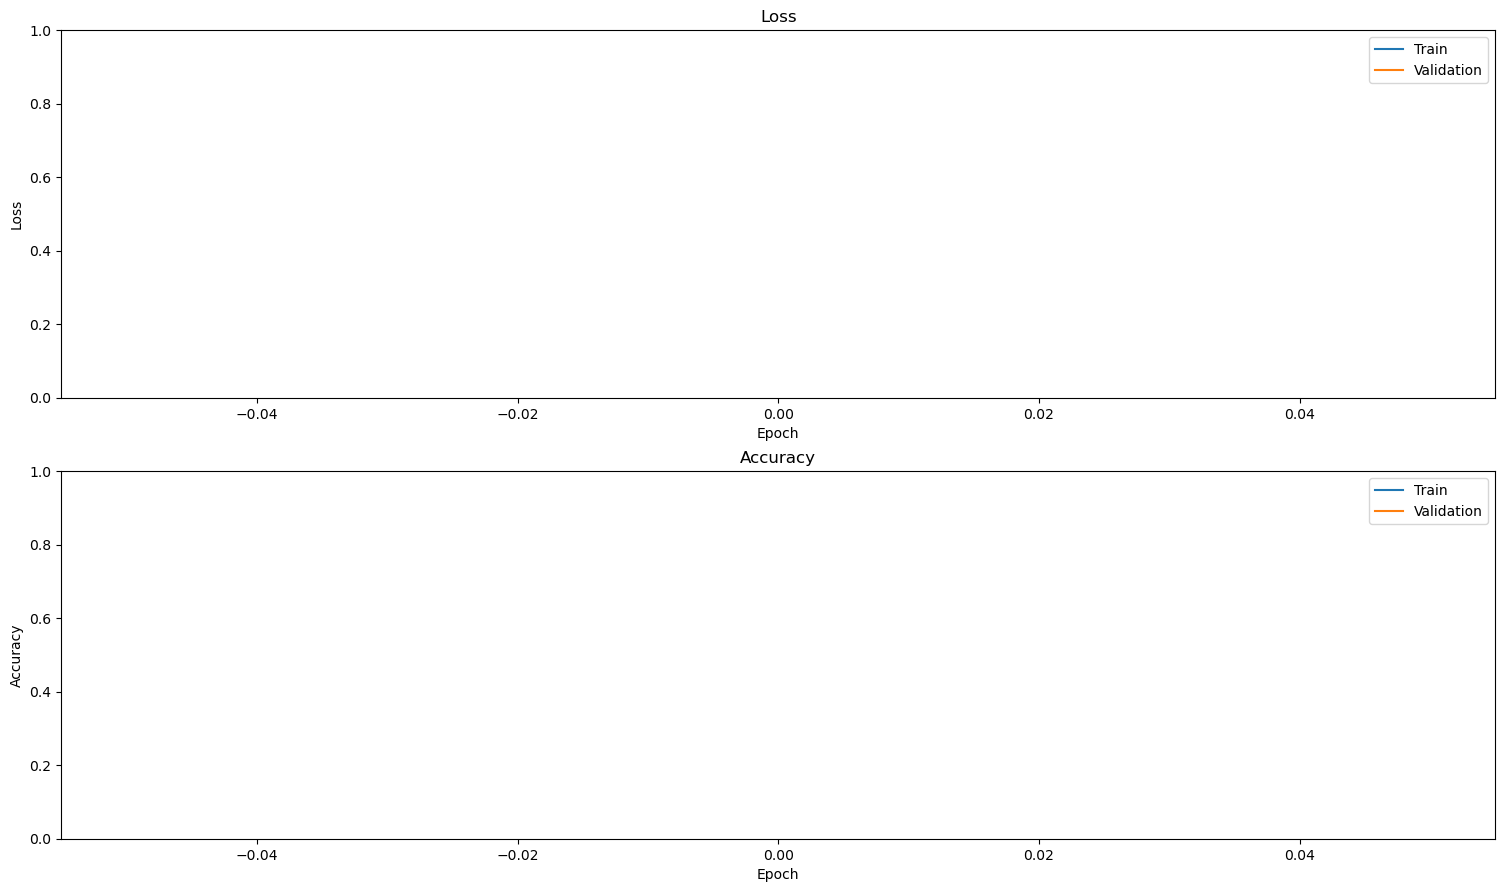

In [40]:
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation']) 

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

plot_history(amc_m1v1_cnn_hist)

#### Evaluate model

In [41]:
amc_m1v1_cnn.evaluate(test_ds,
                      return_dict=True)

41/41 [==============================] - 2946s 67s/step - loss: 0.9174 - accuracy: 0.8637


{'loss': 0.9174199104309082, 'accuracy': 0.8637059926986694}

#### Plot confusion matrices

In [42]:
def get_actual_predicted_labels(dataset, model): 
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

123/123 [==============================] - 6646s 53s/step


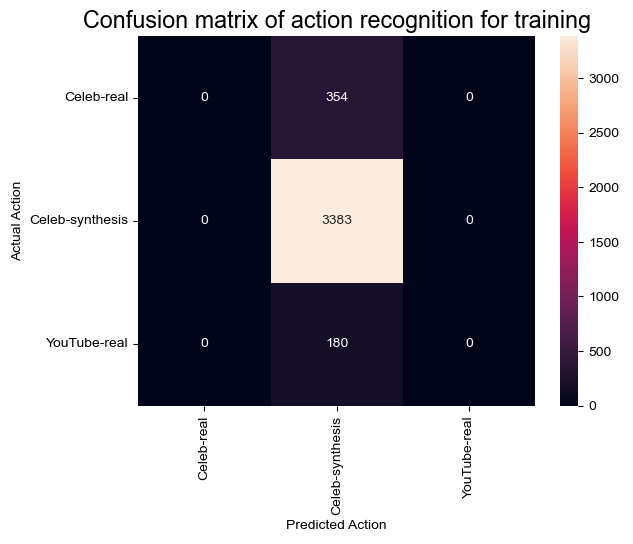

In [43]:
actual, predicted = get_actual_predicted_labels(train_ds, amc_m1v1_cnn)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, amc_m1v1_cnn)
plot_confusion_matrix(actual, predicted, labels, 'test')

     15/Unknown - 865s 48s/step

#### Output precision and recall metrics

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

        recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

print(precision)
print(recall)

### $M_{2}$: Keras sequential structure

In [ ]:
# Start training timer
start_time = dt.datetime.today()

#### Model setup

In [ ]:
K.clear_session()

amc_m2v1_cnn_input_shape = (None, n_frames, image_height, image_width, 3)
print(f'Input shape: {amc_m2v1_cnn_input_shape}')

amc_m2v1_cnn = keras.Sequential([layers.Input(shape=(amc_m2v1_cnn_input_shape[1:])),
                                 
                                 layers.Rescaling(scale=255),
                                 
                                 layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same')),
                                 layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))),
                                 layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same')),
                                 layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))),
                                 layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
                                 layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))),
                                 
                                 layers.TimeDistributed(layers.Flatten()),
                                 
                                 layers.TimeDistributed(layers.Dense(128, activation='relu')),
                                 layers.TimeDistributed(layers.Dense(64, activation='relu')),
                                 layers.TimeDistributed(layers.Dense(64, activation='relu')),
                                 layers.GlobalAveragePooling1D(),
                                 layers.Dense(class_cnt, activation='softmax')
                                ])

#### Review parameters

In [ ]:
keras.utils.plot_model(amc_m2v1_cnn,
                       expand_nested=True,
                       dpi=60,
                       show_shapes=True)

#### Compile and fit

amc_m2v1_cnn.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

amc_m2v1_cnn.fit(train_ds,
                 epochs=target_epochs,
                 validation_data=val_ds)

In [ ]:
# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Training Start Time = {start_time}')
print(f'Training End Time = {end_time}')
print(f'Training Time = {time_elapse}')

### $M_{3}$: Using pretrained model

In [ ]:
# Start training timer
start_time = dt.datetime.today()

#### Model setup

In [ ]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

model = tf.keras.Sequential([tf.keras.layers.Rescaling(scale=255),
                             tf.keras.layers.TimeDistributed(net),
                             tf.keras.layers.Dense(class_cnt),
                             tf.keras.layers.GlobalAveragePooling3D()
                            ])

#### Compile and fit

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs=target_epochs,
          validation_data=val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                                       monitor='val_loss'))

In [ ]:
# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Training Start Time = {start_time}')
print(f'Training End Time = {end_time}')
print(f'Training Time = {time_elapse}')

### $M_{4}$: TensorFlow 2+1D CNN example

In [ ]:
# Start training timer
start_time = dt.datetime.today()

#### Model setup

In [ ]:
K.clear_session()

class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension. 
        """
        super().__init__()
        self.seq = keras.Sequential([  
            # Spatial decomposition
            layers.Conv3D(filters=filters,
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters, 
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding)
        ])

    def call(self, x):
        return self.seq(x)

class ResidualMain(keras.layers.Layer):
    """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
    """
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters, 
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

class Project(keras.layers.Layer):
    """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
    """
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

def add_residual_block(input, filters, kernel_size):
    """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters,
                       kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return layers.add([res, out])

class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        """
        Use the einops library to resize the tensor.  

        Args:
        video: Tensor representation of the video, in the form of a set of frames.

        Return:
        A downsampled size of the video according to the new height and width it should be resized to.
        """
        # b stands for batch size, t stands for time, h stands for height, 
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t = old_shape['t'])
        return videos

amc_m3v1_cnn_input_shape = (None, n_frames, image_height, image_width, 3)
amc_m3v1_cnn_input = layers.Input(shape=(amc_m3v1_cnn_input_shape[1:]))
x = amc_m3v1_cnn_input

x = Conv2Plus1D(filters=16,
                kernel_size=(3, 7, 7),
                padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(image_height // 2, image_width // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(image_height // 4, image_width // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(image_height // 8, image_width // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(image_height // 16, image_width // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(class_cnt)(x)

amc_m3v1_cnn = keras.Model(amc_m3v1_cnn_input, x)

frames, label = next(iter(train_ds))
amc_m3v1_cnn.build(frames)

#### Review parameters

In [ ]:
# Visualize the model
print(f'Frames: {frames.shape}')
keras.utils.plot_model(amc_m3v1_cnn,
                       expand_nested=True,
                       dpi=60,
                       show_shapes=True)

#### Compile and fit

amc_m3v1_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                     optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
                     metrics=['accuracy'])

history = amc_m3v1_cnn.fit(train_ds,
                           epochs=target_epochs,
                           validation_data=val_ds)

In [ ]:
# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Training Start Time = {start_time}')
print(f'Training End Time = {end_time}')
print(f'Training Time = {time_elapse}')

#### Plot accuracy results across epochs

In [ ]:
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation']) 

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

plot_history(history)

#### Evaluate model

In [ ]:
amc_m3v1_cnn.evaluate(test_ds,
                      return_dict=True)

#### Plot confusion matrices

In [ ]:
def get_actual_predicted_labels(dataset): 
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = amc_m3v1_cnn.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

#### Output precision and recall metrics

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

        recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

print(precision)
print(recall)